In [ ]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"

import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
%matplotlib inline
import sys
sys.path.insert(0, os.path.abspath('.'))
sys.path.append(os.path.abspath('../'))
import functools

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put
from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
# from desc.boundary_conditions import get_boundary_condition, LCFSConstraint
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objective_funs import get_objective_function, ForceErrorNodes
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison
from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative

from desc.utils import flatten_list
os.getcwd()

In [ ]:
from desc.optimize.tr_subproblems import trust_region_step_exact_svd
from desc.utils import Timer

def optimal_perturb(
    eq,
    objective,
    dRb=False,
    dZb=False,
    dp=False,
    di=False,
    dPsi=False,
    order=2,
    tr_ratio=0.1,
    cutoff=1e-6,
    Jx=None,
    verbose=1,
    copy=True,
):
    """Perturb an Equilibrium with respect to input parameters to optimize an objective.

    Parameters
    ----------
    eq : Equilibrium
        equilibrium to optimize
    objective : ObjectiveFunction
        objective to optimize
    dRb, dZb, dp, di, dPsi : ndarray or bool
        array of indicies of modes to include in the perturbations of
        R_boundary, Z_boundary, pressure, iota, and toroidal flux.
        Setting to True (False) includes (excludes) all modes.
    order : {0,1,2,3}
        order of perturbation (0=none, 1=linear, 2=quadratic, etc)
    tr_ratio : float or array of float
        radius of the trust region, as a fraction of ||x||.
        enforces ||dx1|| <= tr_ratio*||x|| and ||dx2|| <= tr_ratio*||dx1||
        if a scalar uses same ratio for all steps, if an array uses the first element
        for the first step and so on
    cutoff : float
        relative cutoff for small singular values in pseudoinverse
    Jx : ndarray, optional
        jacobian matrix df/dx
    verbose : int
        level of output to display
    copy : bool
        whether to perturb the input equilibrium or make a copy. Defaults to True

    Returns
    -------
    eq_new : Equilibrium
        optimized equilibrium

    """
    # if not use_jax:
    #     warnings.warn(
    #         colored(
    #             "Computing perturbations with finite differences can be "
    #             + "highly innacurate. Consider using JAX for exact derivatives.",
    #             "yellow",
    #         )
    #     )
    if not eq.objective:
        raise AttributeError(
            "Equilibrium must have objective defined before perturbing."
        )
    if eq.objective.scalar:
        raise AttributeError(
            "Cannot perturb with a scalar objective: {}".format(eq.objective)
        )
    if np.isscalar(tr_ratio):
        tr_ratio = tr_ratio * np.ones(order)
    elif len(tr_ratio) < order:
        raise ValueError(
            "Got only {} tr_ratios for order {} perturbations".format(
                len(tr_ratio), order
            )
        )

    deltas = {}
    if type(dRb) is bool or dRb is None:
        if dRb is True:
            deltas["Rb_lmn"] = np.ones((eq.Rb_basis.num_modes,), dtype=bool)
    elif np.any(dRb):
        deltas["Rb_lmn"] = dRb
    if type(dZb) is bool or dZb is None:
        if dZb is True:
            deltas["Zb_lmn"] = np.ones((eq.Zb_basis.num_modes,), dtype=bool)
    elif np.any(dZb):
        deltas["Zb_lmn"] = dZb
    if type(dp) is bool or dp is None:
        if dp is True:
            deltas["p_l"] = np.ones_like(eq.p_l, dtype=bool)
    elif np.any(dp):
        deltas["p_l"] = dp
    if type(di) is bool or di is None:
        if di is True:
            deltas["i_l"] = np.ones_like(eq.i_l, dtype=bool)
    elif np.any(di):
        deltas["i_l"] = di
    if type(dPsi) is bool or dPsi is None:
        if dPsi is True:
            deltas["Psi"] = np.array([True])
    if not len(deltas):
        raise ValueError("At least one input must be a free variable for optimization.")

    keys = ", ".join(deltas.keys())
    if verbose > 0:
        print("Perturbing {}".format(keys))

    timer = Timer()
    timer.start("Total perturbation")

    Fx = Jx
    arg_idx = {"Rb_lmn": 1, "Zb_lmn": 2, "p_l": 3, "i_l": 4, "Psi": 5}
    if not eq.built:
        eq.build(verbose)
    y = eq.objective.BC_constraint.project(eq.x)
    c = np.array([])
    c_idx = np.array([], dtype=bool)
    for key, idx in deltas.items():
        c = np.concatenate((c, getattr(eq, key)))
        c_idx = np.concatenate((c_idx, idx))
    args = (y, eq.Rb_lmn, eq.Zb_lmn, eq.p_l, eq.i_l, eq.Psi)
    dc1 = 0
    dc2 = 0
    dc3 = 0
    dx1 = 0
    dx2 = 0
    dx3 = 0

    # 1st order
    if order > 0:

        f = eq.objective.compute(*args)  # primary objective residual
        g = objective.compute(*args)  # secondary objective residual

        # Jacobian of primary objective (f) wrt state vector (x)
        if verbose > 0:
            print("Computing df")
        if Fx is None:
            timer.start("df/dx computation")
            Fx = eq.objective.jac_x(*args)
            timer.stop("df/dx computation")
            if verbose > 1:
                timer.disp("df/dx computation")
        Fx_inv = np.linalg.pinv(Fx, rcond=cutoff)

        # Jacobian of primary objective (f) wrt input parameters (c)
        Fc = np.array([])
        timer.start("df/dc computation ({})".format(keys))
        for key in deltas.keys():
            Fc_i = eq.objective.derivative(arg_idx[key], *args)
            Fc = np.hstack((Fc, Fc_i)) if Fc.size else Fc_i
        timer.stop("df/dc computation ({})".format(keys))
        if verbose > 1:
            timer.disp("df/dc computation ({})".format(keys))

        LHS = np.matmul(Fx_inv, Fc)
        RHS_1g = np.matmul(Fx_inv, f)

        # Jacobian of secondary objective (g) wrt state vector (x)
        if verbose > 0:
            print("Computing dg")
        timer.start("dg/dx computation")
        Gx = objective.jac_x(*args)
        timer.stop("dg/dx computation")
        if verbose > 1:
            timer.disp("dg/dx computation")

        # Jacobian of secondary objective (g) wrt input parameters (c)
        Gc = np.array([])
        timer.start("dg/dc computation ({})".format(keys))
        for key in deltas.keys():
            Gc_i = objective.derivative(arg_idx[key], *args)
            Gc = np.hstack((Gc, Gc_i)) if Gc.size else Gc_i
        timer.stop("dg/dc computation ({})".format(keys))
        if verbose > 1:
            timer.disp("dg/dc computation ({})".format(keys))

        LHS = np.matmul(Gx, LHS) - Gc
        RHS_1g = np.matmul(Gx, RHS_1g) - g

        LHS = LHS[:, c_idx]  # restrict optimization space
        uA, sA, vtA = np.linalg.svd(LHS, full_matrices=False)

        # find optimal perturbation
        dc1_opt, hit, alpha_c = trust_region_step_exact_svd(
            RHS_1g,
            uA,
            sA,
            vtA.T,
            tr_ratio[0] * np.linalg.norm(c[c_idx]),
            initial_alpha=None,
            rtol=0.01,
            max_iter=10,
            threshold=1e-6,
        )

        dc1 = np.zeros_like(c)
        dc1[c_idx] = dc1_opt
        inputs = {}
        idx0 = 0
        for key, idx in deltas.items():
            inputs[key] = dc1[idx0 : idx0 + len(idx)]
            idx0 += len(idx)

        RHS_1f = f + np.matmul(Fc, dc1)

        uJ, sJ, vtJ = np.linalg.svd(Fx, full_matrices=False)

        # apply optimal perturbation
        dx1, hit, alpha_x = trust_region_step_exact_svd(
            RHS_1f,
            uJ,
            sJ,
            vtJ.T,
            tr_ratio[0] * np.linalg.norm(y),
            initial_alpha=None,
            rtol=0.01,
            max_iter=10,
            threshold=1e-6,
        )

    # second order
    if order > 1:

        inds = tuple([arg_idx[key] for key in inputs])
        tangents = tuple([val for val in inputs.values()])
        inds = (0, *inds)
        tangents = (dx1, *tangents)

        # Hessian of primary objective (f) wrt both state vector and input parameters
        if verbose > 0:
            print("Computing d^2f")
        timer.start("d^2f computation")
        RHS_2f = 0.5 * eq.objective.jvp2(inds, inds, tangents, tangents, *args)
        RHS_2g = np.matmul(Gx, np.matmul(Fx_inv, RHS_2f))
        timer.stop("d^2f computation")
        if verbose > 1:
            timer.disp("d^2f computation")

        # Hessian of secondary objective (g) wrt both state vector and input parameters
        if verbose > 0:
            print("Computing d^2g")
        timer.start("d^2g computation")
        RHS_2g += -0.5 * objective.jvp2(inds, inds, tangents, tangents, *args)
        timer.stop("d^2g computation")
        if verbose > 1:
            timer.disp("d^2g computation")

        # find optimal perturbation
        dc2_opt, hit, alpha_c = trust_region_step_exact_svd(
            RHS_2g,
            uA,
            sA,
            vtA.T,
            tr_ratio[0] * np.linalg.norm(dc1_opt),
            initial_alpha=alpha_c / tr_ratio[1],
            rtol=0.01,
            max_iter=10,
            threshold=1e-6,
        )

        dc2 = np.zeros_like(c)
        dc2[c_idx] = dc2_opt
        idx0 = 0
        for val in inputs.values():
            val += dc2[idx0 : idx0 + len(val)]
            idx0 += len(val)

        RHS_2f += np.matmul(Fc, dc2)

        # apply optimal perturbation
        dx2, hit, alpha_x = trust_region_step_exact_svd(
            RHS_2f,
            uJ,
            sJ,
            vtJ.T,
            tr_ratio[0] * np.linalg.norm(y),
            initial_alpha=alpha_x / tr_ratio[1],
            rtol=0.01,
            max_iter=10,
            threshold=1e-6,
        )

    if order > 2:
        raise ValueError(
            "Higher-order optimizations not yet implemented: {}".format(order)
        )

    if copy:
        eq_new = eq.copy()
    else:
        eq_new = eq

    # update input parameters
    for key, dc in inputs.items():
        setattr(eq_new, key, getattr(eq_new, key) + dc)

    # update boundary constraint
    if "Rb_lmn" in inputs or "Zb_lmn" in inputs:
        eq_new.objective.BC_constraint = eq.surface.get_constraint(
            eq_new.R_basis, eq_new.Z_basis, eq_new.L_basis
        )

    # update state vector
    dc = dc1 + dc2 + dc3
    dy = dx1 + dx2 + dx3
    eq_new.x = np.copy(eq_new.objective.BC_constraint.recover(y + dy))
    timer.stop("Total perturbation")
    if verbose > 1:
        timer.disp("Total perturbation")
        print("||dc||/||c|| = {}".format(np.linalg.norm(dc) / np.linalg.norm(c[c_idx])))
        print("||dx||/||x|| = {}".format(np.linalg.norm(dy) / np.linalg.norm(y)))

    return eq_new


In [ ]:
# from desc.nestor import Nestor
from desc.magnetic_fields import SplineMagneticField
from desc.vmec_utils import ptolemy_identity_fwd
from desc.utils import copy_coeffs
from desc.profiles import SplineProfile

def nestor_to_eq(vacin):

    ntor    = int(vacin['ntor'][()])
    mpol    = int(vacin['mpol'][()])
    nzeta   = int(vacin['nzeta'][()])
    ntheta  = int(vacin['ntheta'][()])
    NFP     = int(vacin['nfp'][()])
    sym     = bool(vacin['lasym__logical__'][()] == 0)

    raxis   = vacin['raxis_nestor'][()]
    zaxis   = vacin['zaxis_nestor'][()]
    wint    = np.array(vacin['wint'][()])

    xm      = vacin['xm'][()]
    xn      = vacin['xn'][()]
    rmnc    = vacin['rmnc'][()]
    zmns    = vacin['zmns'][()]

    bdry_grid = LinearGrid(rho=1, M=ntheta, N=nzeta, NFP=NFP)
    mr, nr, Rb_mn = ptolemy_identity_fwd(xm, xn//NFP, np.zeros_like(rmnc), rmnc)
    mz, nz, Zb_mn = ptolemy_identity_fwd(xm, xn//NFP, zmns, np.zeros_like(zmns))
    M = max(np.max(abs(mr)),np.max(abs(mz)))
    N = max(np.max(abs(nr)),np.max(abs(nz)))        
    Rb_mn = Rb_mn[0]
    Zb_mn = Zb_mn[0]
    modes_Rb = np.array([np.zeros_like(mr), mr, nr]).T
    modes_Zb = np.array([np.zeros_like(mz), mz, nz]).T
        
    a_basis = FourierSeries(N=N, NFP=NFP, sym=False)
    axis_grid = LinearGrid(rho=0, theta=0, N=nzeta, NFP=NFP)
    a_transform = Transform(axis_grid, a_basis, build=True, build_pinv=True)
    Ra_n = a_transform.fit(raxis)
    Za_n = a_transform.fit(zaxis)


    temp_basis = DoubleFourierSeries(M=M, N=N, NFP=NFP, sym=False)
    Rb_lmn = copy_coeffs(Rb_mn, modes_Rb, temp_basis.modes).reshape((-1,1))
    Zb_lmn = copy_coeffs(Zb_mn, modes_Zb, temp_basis.modes).reshape((-1,1))
    boundary = np.hstack([temp_basis.modes, Rb_lmn, Zb_lmn])
    axis = np.hstack([a_basis.modes[:,2:], Ra_n[:,np.newaxis], Za_n[:,np.newaxis]])
    profiles = np.array([0,0,0]).reshape((1,3))
    eq = {"L": 2*M,
          "M": M,
          "N": N,
          "pressure": profiles[:,:2],
          "iota": profiles[:,(0,2)],
          "surface": boundary,
          "NFP": NFP,
          "Psi": 1.0,
          "axis": axis,
          "sym": sym,
          "node_pattern": "jacobi",
          "spectral_indexing": "fringe",
    }
    eq = Equilibrium(**eq)
    return eq
    
# vacin iter0
vacini = Dataset("../educational_VMEC/test/vac/vacin_test_iota.vmec_000000.nc", "r")
vacinf = Dataset("../educational_VMEC/test/vac/vacin_test_iota.vmec_001055.nc", "r")

ntor    = int(vacini['ntor'][()])
mpol    = int(vacini['mpol'][()])
nzeta   = int(vacini['nzeta'][()])
ntheta  = int(vacini['ntheta'][()])
NFP     = int(vacini['nfp'][()])
sym     = bool(vacini['lasym__logical__'][()] == 0)

rbtor   = vacini['rbtor'][()][()]
ctor    = vacini['ctor'][()][()]
signgs  = vacini['signgs'][()][()]

mgrid = "tests/inputs/nestor/mgrid_test.nc"
extcur = vacini['extcur'][()]        
folder = os.getcwd()
mgridFilename = os.path.join(folder, mgrid)
ext_field = SplineMagneticField.from_mgrid(mgridFilename, extcur, extrap=True, period=(2*np.pi/NFP))

mf = mpol+1
nf = ntor


# ir = InputReader("/home/fouriest/SCHOOL/Princeton/PPPL/educational_VMEC/test/input.test_vac.vmec_desc")
# inputs = ir.inputs[0]
# eq = Equilibrium(**inputs)
# eq.change_resolution(M=6, N=6, L=12, L_grid=15, M_grid=9, N_grid=9)
# eq.x0 = eq.x

veq = VMECIO.load("../educational_VMEC/test/wout_test_iota.vmec.nc", spectral_indexing="fringe")
veq.change_resolution(L=12, M=6, N=6, L_grid=15, M_grid=9, N_grid=9)

# eq.change_resolution(M=veq.M, N=veq.N, L=veq.L, L_grid=veq.L_grid, M_grid=veq.M_grid, N_grid=veq.N_grid)

f = Dataset("../educational_VMEC/test/wout_test_iota.vmec.nc")
pres = np.asarray(f.variables['presf'])
sp = np.linspace(0,1,pres.size)
rp = np.sqrt(sp)
# pres[0] = pres[1]
pressure = SplineProfile(pres, rp)

iot = np.asarray(f.variables['iotaf'])
si = np.linspace(0,1,iot.size)
ri = np.sqrt(si)
iota = SplineProfile(iot, ri)


veq.pressure = pressure
veq.iota = iota


veq.objective="force"
veq.optimizer = "lsq-exact"


veq.build()
veq.objective.build()



In [ ]:
# veq.change_resolution(16,5,4,20,10,30)
veq.resolution_summary()
veq.solve(ftol=1e-2, xtol=1e-6, gtol=1e-6, maxiter=1000, verbose=3);

In [ ]:
fig, ax = VMECIO.plot_vmec_comparison(veq, "../educational_VMEC/test/wout_test_iota.vmec.nc")

In [ ]:
data = veq.compute("W")
100*abs(data["W_p"] / data["W_B"])

In [ ]:
fig, ax = VMECIO.plot_vmec_comparison(veq, "../educational_VMEC/test/wout_test_iota.vmec.nc")

In [ ]:
surf = veq.get_surface_at(1)
surf.change_resolution(M=1, N=0)
eq = Equilibrium(Psi=veq.Psi, pressure=veq.pressure, iota=veq.iota, spectral_indexing=veq.spectral_indexing, sym=veq.sym, NFP=veq.NFP)

In [ ]:
eq.set_initial_guess(surf)
eq.surface = surf
eq.change_resolution(veq.L//2, veq.M//2, veq.N//2, veq.L_grid, veq.M_grid, veq.N_grid)

In [ ]:
veq.resolution_summary()
eq.resolution_summary()
print(veq.x.size)
print(eq.x.size)

In [ ]:
eq.objective="force"
eq.optimizer="lsq-exact"
eq.solve(ftol=1e-2, verbose=3);

In [ ]:
plot_surfaces(eq);

In [ ]:
eq.change_resolution(veq.L, veq.M, veq.N, veq.L_grid, veq.M_grid, veq.N_grid)

In [ ]:
eq.objective="force"
eq.optimizer="lsq-exact"
eq.solve(ftol=1e-2, verbose=3);

In [ ]:
plot_surfaces(eq);

In [ ]:
plot_comparison([eq, veq]);

In [ ]:
from desc.objective_funs import ObjectiveFunction
from desc.compute import compute_contravariant_basis, compute_contravariant_magnetic_field, compute_pressure
from desc.utils import unpack_state
from desc.geometry.utils import rpz2xyz, rpz2xyz_vec, xyz2rpz_vec, rotation_matrix

@jax.jit  
def biot_loop(re, rs, J, dV):
    """
    
    Parameters
    ----------
    re : ndarray, shape(n_eval_pts, 3)
        evaluation points
    rs : ndarray, shape(n_src_pts, 3)
        source points
    J : ndarray, shape(n_src_pts, 3)
        current density vector at source points
    dV : ndarray, shape(n_src_pts)
        volume element at source points
    """
    re, rs, J, dV = map(jnp.asarray, (re, rs, J, dV))
    assert J.shape == rs.shape
    JdV = J * dV[:, None]
    B = jnp.zeros_like(re)
    def body(i, B):
        r = re - rs[i,:]
        num = jnp.cross(JdV[i,:], r, axis=-1)
        den = jnp.linalg.norm(r, axis=-1)**3
        B = B + jnp.where(den[:,None]==0, 0, num/den[:,None])
        return B
    return 1e-7 * jax.lax.fori_loop(0, J.shape[0], body, B)

@jax.jit
def biot_loop_periods(re, rs, J, dV, NFP):
    
    dphi = 2*np.pi/NFP
    R = rotation_matrix([0,0,1], dphi)
    B = jnp.zeros_like(re)
    Ri = jnp.eye(3)
    def body(i, B_Ri):
        B, Ri = B_Ri
        rsi = (Ri @ rs.T).T
        Ji = (Ri @ J.T).T
        B = B + biot_loop(re, rsi, Ji, dV)
        Ri = R @ Ri
        return B, Ri
    return jax.lax.fori_loop(0, NFP, body, (B,Ri))[0]

class BoundaryErrorBS(ObjectiveFunction):

    def __init__(self, ext_field, BeR_transform, BeZ_transform, BeL_transform, Bep_profile, Bei_profile, 
                 BsR_transform, BsZ_transform, BsL_transform, Bsp_profile, Bsi_profile): 
        
        self.ext_field = ext_field
        self.BeR_transform = BeR_transform.copy(True)
        self.BeZ_transform = BeZ_transform.copy(True)
        self.BeL_transform = BeL_transform.copy(True)
        self.Bep_profile = Bep_profile.copy(True)
        self.Bei_profile = Bei_profile.copy(True)
        self.BsR_transform = BsR_transform.copy(True)
        self.BsZ_transform = BsZ_transform.copy(True)
        self.BsL_transform = BsL_transform.copy(True)
        self.Bsp_profile = Bsp_profile.copy(True)
        self.Bsi_profile = Bsi_profile.copy(True)
        self.NFP = BsR_transform.grid.NFP
        
    @property
    def scalar(self):
        """Whether default "compute" method is a scalar or vector (bool)."""
        return False

    @property
    def name(self):
        """Name of objective function (str)."""
        return "boundary"

    def build(self, *args, **kwargs):
        self.set_derivatives()
    
    @property
    def derivatives(self):
        """Which derivatives are needed to compute (ndarray)."""
        # TODO: different derivatives for R,Z,L,p,i ?
        # old axis derivatives
        # axis = np.array([[2, 1, 0], [1, 2, 0], [1, 1, 1], [2, 2, 0]])
        derivatives = np.array(
            [
                [0, 0, 0],
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1],
                [2, 0, 0],
                [0, 2, 0],
                [0, 0, 2],
                [1, 1, 0],
                [1, 0, 1],
                [0, 1, 1],
            ]
        )
        return derivatives

    def compute(self, x, Rb_lmn, Zb_lmn, p_l, i_l, Psi):
        if self.BC_constraint is not None and x.size == self.dimy:
            # x is really 'y', need to recover full state vector
            x = self.BC_constraint.recover_from_constraints(x, Rb_lmn, Zb_lmn)

        R_lmn, Z_lmn, L_lmn = unpack_state(
            x, self.BeR_transform.basis.num_modes, self.BeZ_transform.basis.num_modes
        )
        
        Bdata_src = compute_contravariant_magnetic_field(R_lmn, Z_lmn, L_lmn, i_l, Psi, self.BsR_transform, self.BsZ_transform, 
                                   self.BsL_transform, self.Bsi_profile)
        ndata_src = compute_contravariant_basis(R_lmn, Z_lmn, self.BsR_transform, self.BsZ_transform)
        Bdata_eval = compute_contravariant_magnetic_field(R_lmn, Z_lmn, L_lmn, i_l, Psi, self.BeR_transform, self.BeZ_transform, 
                                   self.BeL_transform, self.Bei_profile)
        ndata_eval = compute_contravariant_basis(R_lmn, Z_lmn, self.BeR_transform, self.BeZ_transform)
        pdata_eval = compute_pressure(p_l, self.Bep_profile)


        Bsrc = Bdata_src['B']
        Bsrc = rpz2xyz_vec(Bsrc, phi=self.BsR_transform.grid.nodes[:,2])
        nsrc = ndata_src['e^rho'] / jnp.linalg.norm(ndata_src['e^rho'], axis=1)[:,np.newaxis]
        nsrc = rpz2xyz_vec(nsrc, phi=self.BsR_transform.grid.nodes[:,2])
        J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0

        neval = ndata_eval['e^rho'] / jnp.linalg.norm(ndata_eval['e^rho'], axis=1)[:,np.newaxis]
        neval = rpz2xyz_vec(neval, phi=self.BeR_transform.grid.nodes[:,2])

        rsrc = jnp.array([Bdata_src['R'], self.BsR_transform.grid.nodes[:,2], Bdata_src['Z']]).T
        rsrc = rpz2xyz(rsrc)
        reval = jnp.array([Bdata_eval['R'], self.BeR_transform.grid.nodes[:,2], Bdata_eval['Z']]).T
        reval = rpz2xyz(reval)

        dVeval = abs(Bdata_eval['|e_theta x e_zeta|'] * self.BeR_transform.grid.weights)  # TODO: change to spacing
        dVsrc = abs(Bdata_src['|e_theta x e_zeta|'] * self.BsR_transform.grid.weights)  # TODO: change to spacing
        
        B_tot = rpz2xyz_vec(Bdata_eval['B'], phi=self.BeR_transform.grid.nodes[:,2])
        B_plasma = biot_loop_periods(reval, rsrc, J, dVsrc/self.NFP, self.NFP) + B_tot/2
        B_ex = self.ext_field.compute_magnetic_field(reval, basis="xyz")
        B_in = B_tot 
        B_out = B_ex + B_plasma
        Bsq_in = jnp.sum(B_in**2, axis=-1) + 2*mu_0*pdata_eval['p']
        Bsq_out = jnp.sum(B_out**2, axis=-1)
        Bsq_diff = (Bsq_in - Bsq_out)*dVeval
        Bn = jnp.sum(B_out*neval, axis=-1)*dVeval
        return jnp.concatenate([Bsq_diff, Bn])
    
    def compute_scalar(self, x, Rb_lmn, Zb_lmn, p_l, i_l, Psi):
        """Compute the total force balance error.

        eg 1/2 sum(f**2)

        Parameters
        ----------
        x : ndarray
            optimization state vector
        Rb_lmn : ndarray
            array of fourier coefficients for R boundary
        Zb_lmn : ndarray
            array of fourier coefficients for Z boundary
        p_l : ndarray
            series coefficients for pressure profile
        i_l : ndarray
            series coefficients for iota profile
        Psi : float
            toroidal flux within the last closed flux surface in webers

        Returns
        -------
        f : float
            total force balance error
        """
        residual = self.compute(x, Rb_lmn, Zb_lmn, p_l, i_l, Psi)
        residual = 1 / 2 * jnp.sum(residual ** 2)
        return residual

    def callback(self, x, Rb_lmn, Zb_lmn, p_l, i_l, Psi):
        return None


In [ ]:
def print_error_summary(eqis):
    for eqi in eqis:
        f = eq.objective.compute_scalar(eqi.x, eqi.Rb_lmn, eqi.Zb_lmn, eqi.p_l, eqi.i_l, eqi.Psi)
        b = bc_objective.compute_scalar(eqi.x, eqi.Rb_lmn, eqi.Zb_lmn, eqi.p_l, eqi.i_l, eqi.Psi)
        print("F^2: {:.4e}      B^2: {:.4e}".format(f,b))
    

In [18]:
ntheta = 4*eq.M_grid+1
nzeta = 4*eq.N_grid+1

Begrid = LinearGrid(M=ntheta,N=nzeta, rho=1, NFP=eq.NFP) 
Begrid.nodes += np.array([0, np.pi/ntheta, np.pi/nzeta/eq.NFP])
BeR_transform = Transform(Begrid, eq.R_basis, derivs=1)
BeZ_transform = Transform(Begrid, eq.Z_basis, derivs=1)
BeL_transform = Transform(Begrid, eq.L_basis, derivs=1)

Bsgrid = LinearGrid(M=ntheta,N=nzeta, rho=1, NFP=eq.NFP) 
BsR_transform = Transform(Bsgrid, eq.R_basis, derivs=1)
BsZ_transform = Transform(Bsgrid, eq.Z_basis, derivs=1)
BsL_transform = Transform(Bsgrid, eq.L_basis, derivs=1)


Bep_profile = eq.pressure.copy()
Bei_profile = eq.iota.copy()
Bsp_profile = eq.pressure.copy()
Bsi_profile = eq.iota.copy()
Bep_profile.grid = Begrid
Bei_profile.grid = Begrid
Bsp_profile.grid = Bsgrid
Bsi_profile.grid = Bsgrid

In [19]:
bc_objective = BoundaryErrorBS(ext_field, BeR_transform, BeZ_transform, BeL_transform, Bep_profile, Bei_profile, 
                 BsR_transform, BsZ_transform, BsL_transform, Bsp_profile, Bsi_profile)
bc_objective.BC_constraint = eq.objective.BC_constraint
bc_objective.dimy = eq.objective.dimy
bc_objective.dimf = Begrid.num_nodes*3
bc_objective.build()

In [20]:
print(bc_objective.compute_scalar(eq.x, eq.Rb_lmn, eq.Zb_lmn, eq.p_l, eq.i_l, eq.Psi))
print(bc_objective.compute_scalar(veq.x, veq.Rb_lmn, veq.Zb_lmn, veq.p_l, veq.i_l, veq.Psi))

0.0001412468055334391
3.040224633490283e-07


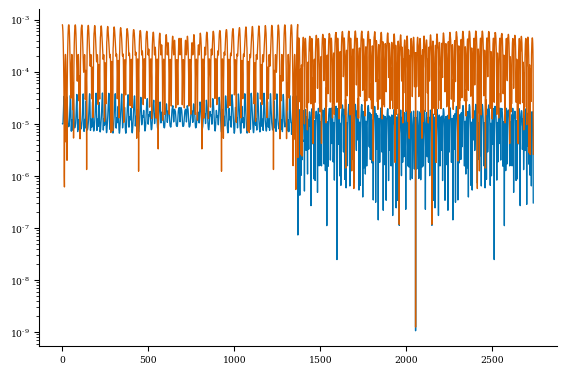

In [21]:
plt.semilogy(abs(bc_objective.compute(veq.x, veq.Rb_lmn, veq.Zb_lmn, veq.p_l, veq.i_l, veq.Psi)))
plt.semilogy(abs(bc_objective.compute(eq.x, eq.Rb_lmn, eq.Zb_lmn, eq.p_l, eq.i_l, eq.Psi)))

In [29]:
eq = veq

In [22]:
eqs = [eq]
eq.Rb_basis = eq.surface.R_basis
eq.Zb_basis = eq.surface.Z_basis
eq_temp = optimal_perturb(
    eq,
    bc_objective,
    dRb=True,
    dZb=True,
    dp=False,
    di=False,
    dPsi=False,
    order=2,
    tr_ratio=0.01,
    cutoff=1e-6,
    Jx=None,
    verbose=3,
    copy=True,)
eqs.append(eq_temp)
eqs[-1].objective = eqs[0].objective
eqs[-1].solve(maxiter=50);

Perturbing Rb_lmn, Zb_lmn
Precomputing Transforms
Timer: Transform computation = 350 ms
Factorizing boundary constraint
Timer: Boundary constraint factorization = 1.82 ms
Computing df
Timer: df/dx computation = 531 ms
Timer: df/dc computation (Rb_lmn, Zb_lmn) = 42.3 sec
Computing dg
Timer: dg/dx computation = 1.69 min
Timer: dg/dc computation (Rb_lmn, Zb_lmn) = 1.64 min
Computing d^2f
Timer: d^2f computation = 50.9 sec
Computing d^2g
Timer: d^2g computation = 1.16 min
Timer: Total perturbation = 6.56 min
||dc||/||c|| = 0.00996846817569264
||dx||/||x|| = 0.014195550031367448
Precomputing transforms
Compiling objective function and derivatives
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 8.910e-01
         Iterations: 21
         Function evaluations: 22
         Jacobian evaluations: 22
Start of solver
Total residual:  1.065e+06  f_rho:  1.445e+03  f_beta:  2.023e+02
End of solver
Total residual:  8.910e-01  f_r

In [23]:
print_error_summary(eqs)

F^2: 4.8238e-06      B^2: 1.4125e-04
F^2: 8.9097e-01      B^2: 7.4238e-05


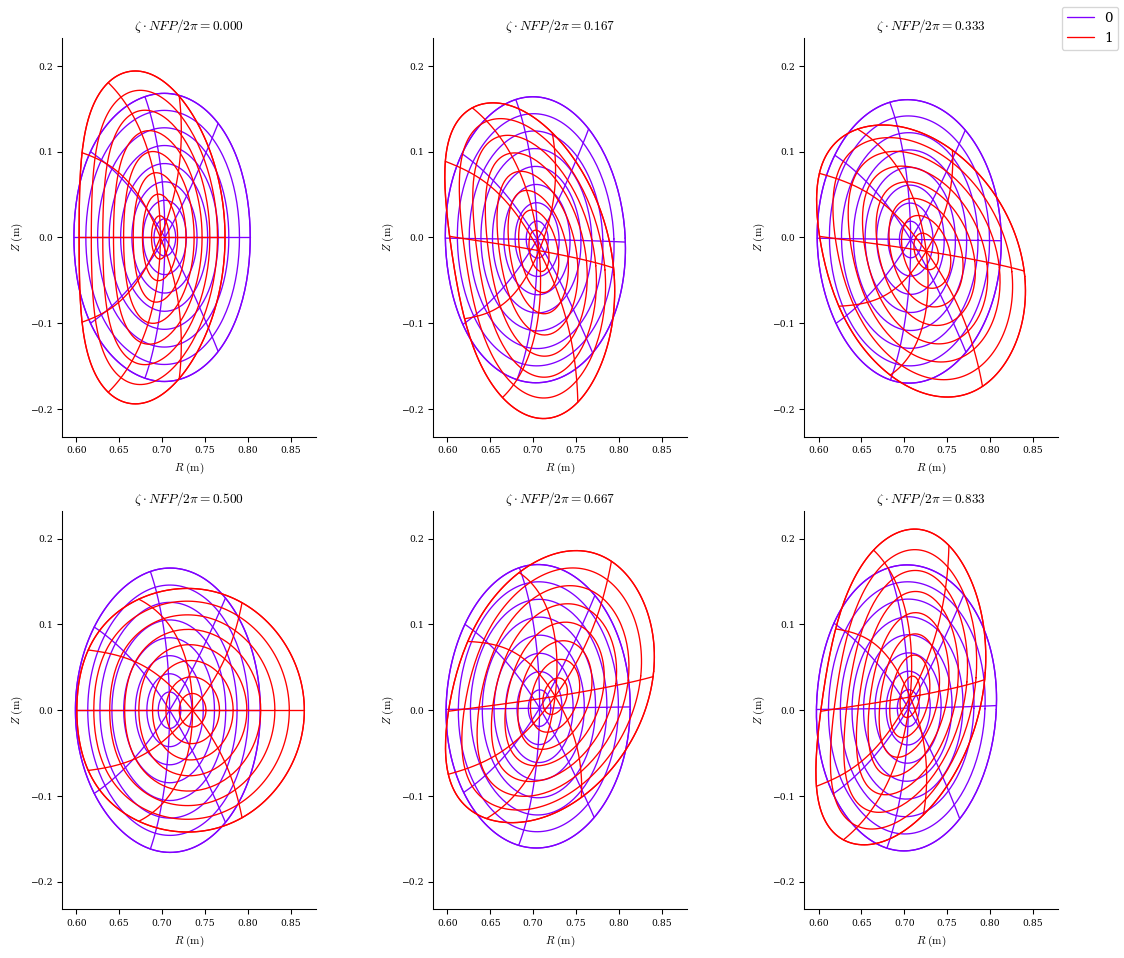

In [24]:
plot_comparison([eqs[-1]] + [veq]);

In [25]:
eqs[-1].Rb_basis = eq.surface.R_basis
eqs[-1].Zb_basis = eq.surface.Z_basis
eq_temp = optimal_perturb(
    eqs[-1],
    bc_objective,
    dRb=True,
    dZb=True,
    dp=False,
    di=False,
    dPsi=False,
    order=2,
    tr_ratio=0.01,
    cutoff=1e-6,
    Jx=None,
    verbose=3,
    copy=True,)
eqs.append(eq_temp)
eqs[-1].objective = eqs[0].objective
eqs[-1].solve(maxiter=50);

Perturbing Rb_lmn, Zb_lmn
Computing df
Timer: df/dx computation = 602 ms
Timer: df/dc computation (Rb_lmn, Zb_lmn) = 51.8 sec
Computing dg
Timer: dg/dx computation = 1.24 min
Timer: dg/dc computation (Rb_lmn, Zb_lmn) = 19.7 sec
Computing d^2f
Timer: d^2f computation = 54.8 sec
Computing d^2g
Timer: d^2g computation = 1.11 sec
Timer: Total perturbation = 3.44 min
||dc||/||c|| = 0.010067743152371864
||dx||/||x|| = 0.014273794558575114
Precomputing transforms
Compiling objective function and derivatives
Starting optimization
         Current function value: 6.473e+03
         Iterations: 39
         Function evaluations: 50
         Jacobian evaluations: 40
Start of solver
Total residual:  6.686e+05  f_rho:  1.055e+03  f_beta:  4.736e+02
End of solver
Total residual:  6.473e+03  f_rho:  7.603e+01  f_beta:  8.464e+01


In [26]:
print_error_summary(eqs)

F^2: 4.8238e-06      B^2: 1.4125e-04
F^2: 8.9097e-01      B^2: 7.4238e-05
F^2: 6.4726e+03      B^2: 4.0593e-05


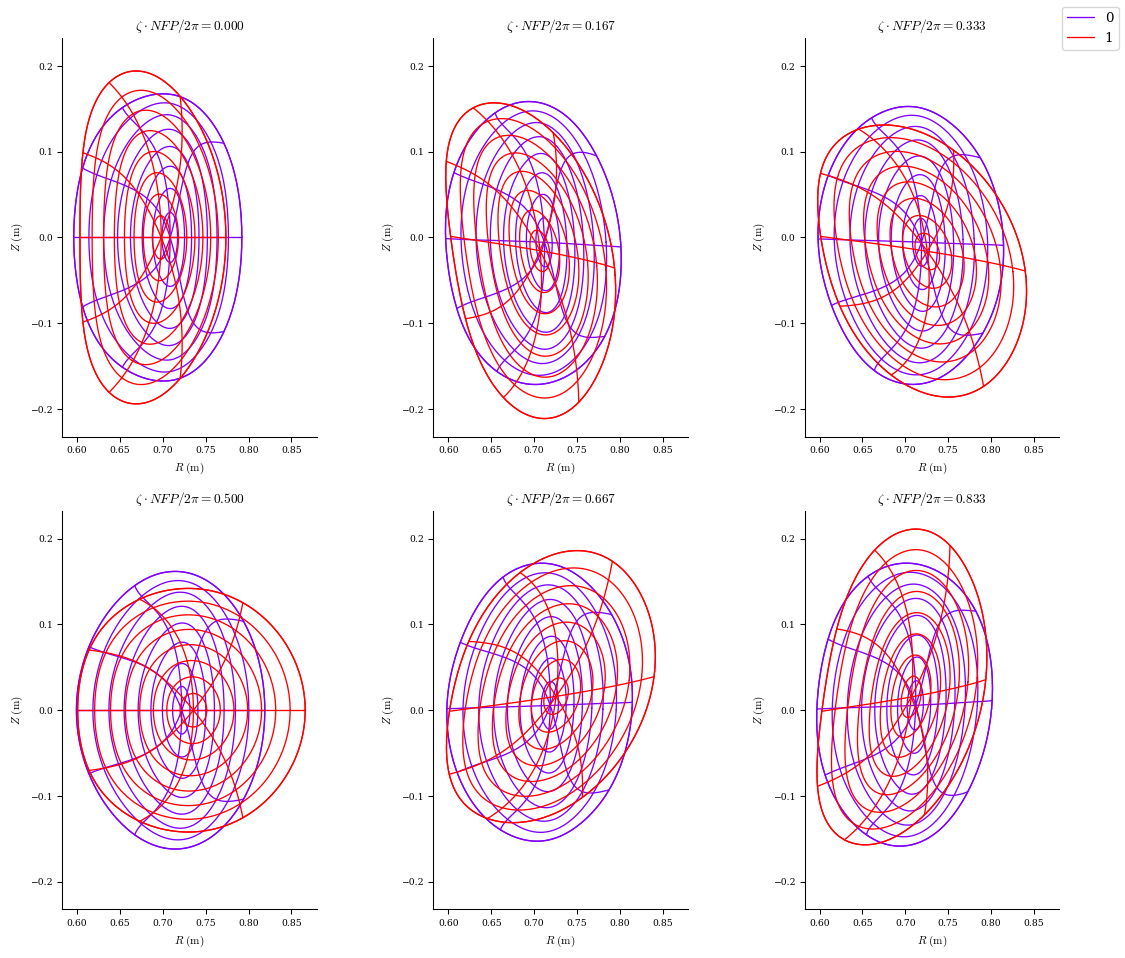

In [27]:
plot_comparison([eqs[-1]] + [veq]);

In [28]:
eqs[-1].Rb_basis = eq.surface.R_basis
eqs[-1].Zb_basis = eq.surface.Z_basis
eq_temp = optimal_perturb(
    eqs[-1],
    bc_objective,
    dRb=True,
    dZb=True,
    dp=False,
    di=False,
    dPsi=False,
    order=2,
    tr_ratio=0.01,
    cutoff=1e-6,
    Jx=None,
    verbose=3,
    copy=True,)
eqs.append(eq_temp)
eqs[-1].objective = eqs[0].objective
eqs[-1].solve(maxiter=50);

Perturbing Rb_lmn, Zb_lmn
Computing df
Timer: df/dx computation = 523 ms
Timer: df/dc computation (Rb_lmn, Zb_lmn) = 41.4 sec
Computing dg
Timer: dg/dx computation = 1.05 min
Timer: dg/dc computation (Rb_lmn, Zb_lmn) = 17.0 sec
Computing d^2f
Timer: d^2f computation = 49.8 sec
Computing d^2g
Timer: d^2g computation = 1.00 sec
Timer: Total perturbation = 2.93 min
||dc||/||c|| = 0.01001412099919408
||dx||/||x|| = 0.014446075821023613
Precomputing transforms
Compiling objective function and derivatives
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 1.087e+04
         Iterations: 18
         Function evaluations: 25
         Jacobian evaluations: 19
Start of solver
Total residual:  2.372e+06  f_rho:  1.529e+03  f_beta:  1.552e+03
End of solver
Total residual:  1.087e+04  f_rho:  1.028e+02  f_beta:  1.057e+02


In [29]:
print_error_summary(eqs)

F^2: 4.8238e-06      B^2: 1.4125e-04
F^2: 8.9097e-01      B^2: 7.4238e-05
F^2: 6.4726e+03      B^2: 4.0593e-05
F^2: 1.0865e+04      B^2: 2.4796e-05


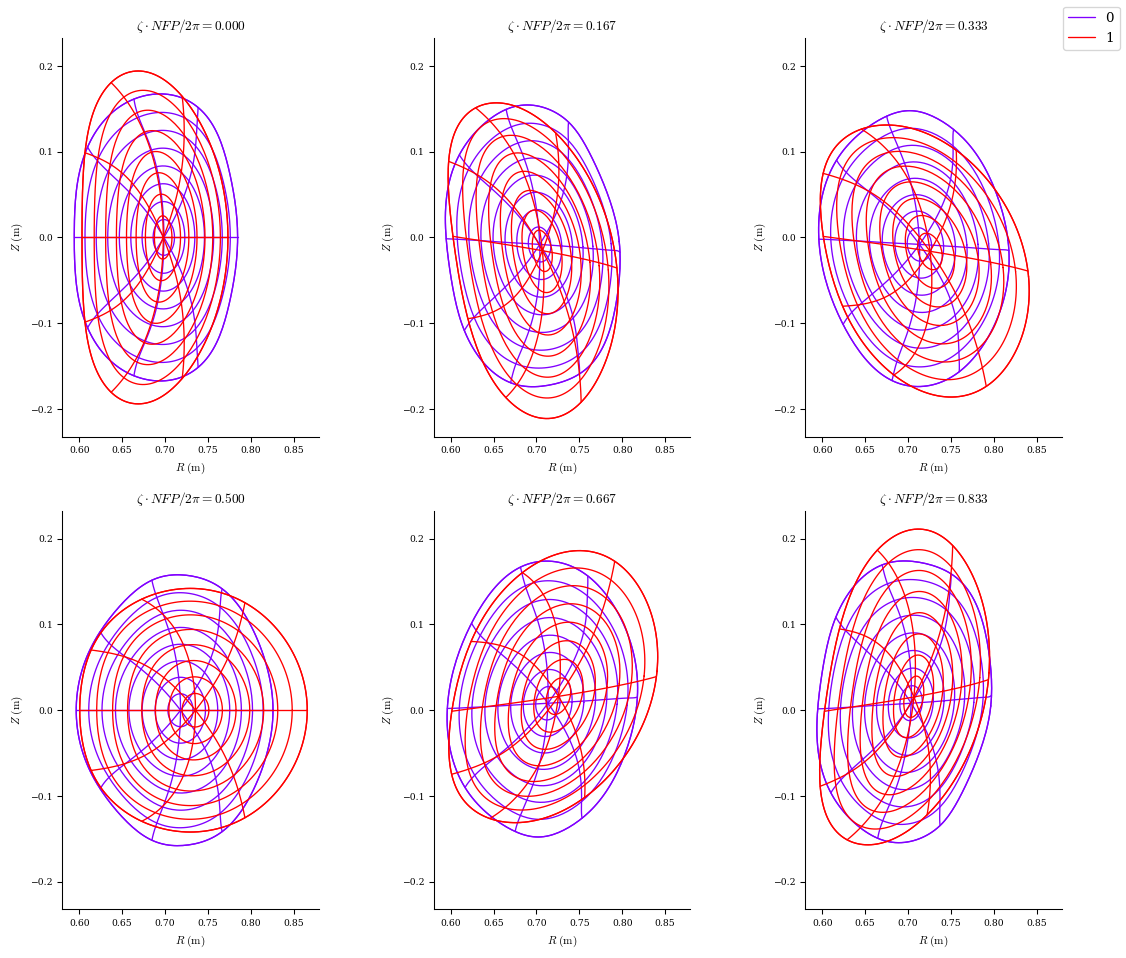

In [30]:
plot_comparison([eqs[-1]] + [veq]);

In [31]:
eqs[-1].Rb_basis = eq.surface.R_basis
eqs[-1].Zb_basis = eq.surface.Z_basis
eq_temp = optimal_perturb(
    eqs[-1],
    bc_objective,
    dRb=True,
    dZb=True,
    dp=False,
    di=False,
    dPsi=False,
    order=2,
    tr_ratio=0.05,
    cutoff=1e-6,
    Jx=None,
    verbose=3,
    copy=True,)
eqs.append(eq_temp)
eqs[-1].objective = eqs[0].objective
eqs[-1].solve(maxiter=50);

Perturbing Rb_lmn, Zb_lmn
Computing df
Timer: df/dx computation = 699 ms
Timer: df/dc computation (Rb_lmn, Zb_lmn) = 42.8 sec
Computing dg
Timer: dg/dx computation = 1.04 min
Timer: dg/dc computation (Rb_lmn, Zb_lmn) = 17.2 sec
Computing d^2f
Timer: d^2f computation = 50.5 sec
Computing d^2g
Timer: d^2g computation = 997 ms
Timer: Total perturbation = 2.96 min
||dc||/||c|| = 0.05250678066077242
||dx||/||x|| = 0.06466473939369703
Precomputing transforms
Compiling objective function and derivatives
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 2.614e+03
         Iterations: 13
         Function evaluations: 16
         Jacobian evaluations: 14
Start of solver
Total residual:  8.634e+06  f_rho:  3.900e+03  f_beta:  1.436e+03
End of solver
Total residual:  2.614e+03  f_rho:  4.325e+01  f_beta:  5.795e+01


In [32]:
print_error_summary(eqs)

F^2: 4.8238e-06      B^2: 1.4125e-04
F^2: 8.9097e-01      B^2: 7.4238e-05
F^2: 6.4726e+03      B^2: 4.0593e-05
F^2: 1.0865e+04      B^2: 2.4796e-05
F^2: 2.6143e+03      B^2: 5.2573e-07


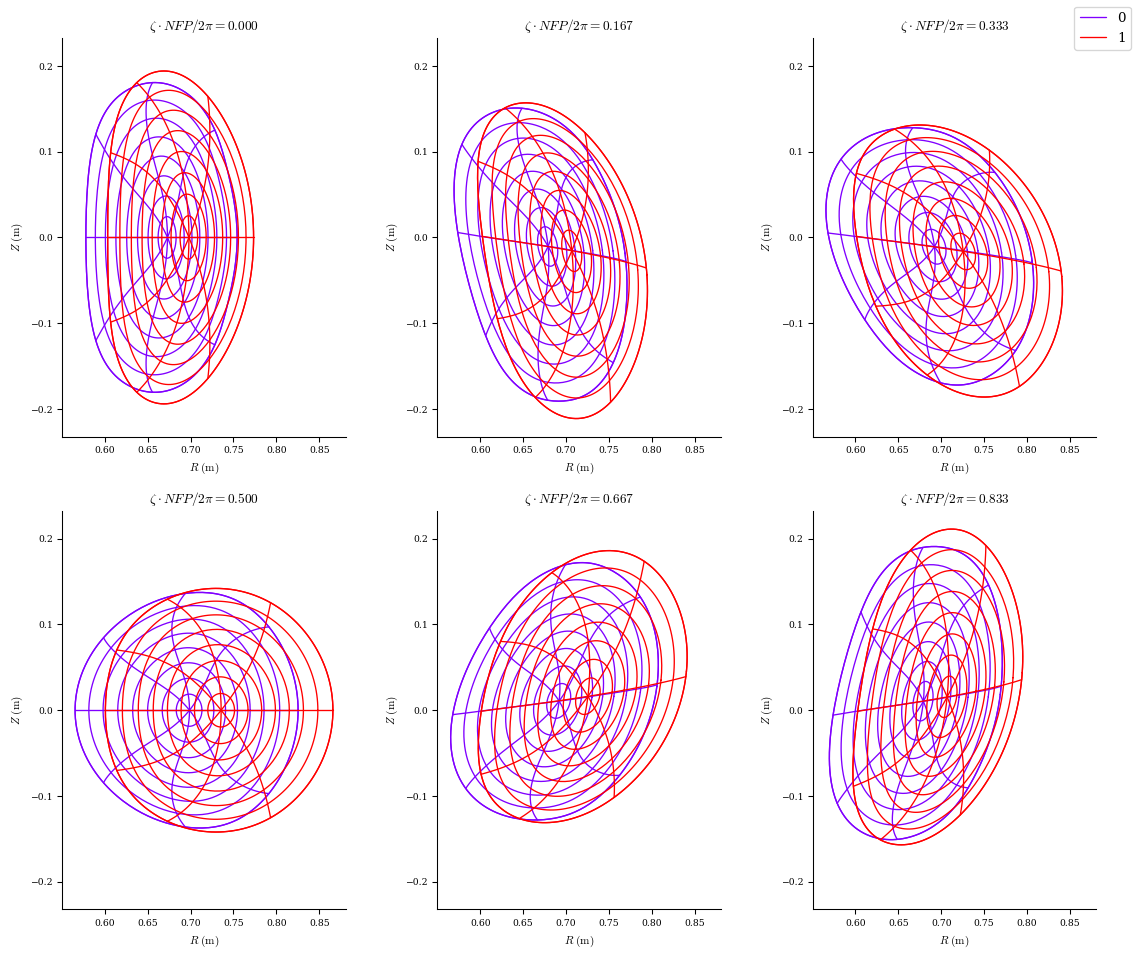

In [33]:
plot_comparison([eqs[-1]] + [veq]);

In [34]:
eq_temp = optimal_perturb(
    eqs[-1],
    bc_objective,
    dRb=True,
    dZb=True,
    dp=False,
    di=False,
    dPsi=False,
    order=2,
    tr_ratio=0.05,
    cutoff=1e-6,
    Jx=None,
    verbose=3,
    copy=True,)
eqs.append(eq_temp)
eqs[-1].solve(maxiter=50);

Perturbing Rb_lmn, Zb_lmn
Computing df
Timer: df/dx computation = 566 ms
Timer: df/dc computation (Rb_lmn, Zb_lmn) = 42.3 sec
Computing dg
Timer: dg/dx computation = 1.05 min
Timer: dg/dc computation (Rb_lmn, Zb_lmn) = 16.9 sec
Computing d^2f
Timer: d^2f computation = 52.0 sec
Computing d^2g
Timer: d^2g computation = 929 ms
Timer: Total perturbation = 2.99 min
||dc||/||c|| = 0.050204174705037914
||dx||/||x|| = 0.07302798375546261
Precomputing transforms
Compiling objective function and derivatives
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 2.946e+03
         Iterations: 15
         Function evaluations: 16
         Jacobian evaluations: 16
Start of solver
Total residual:  4.976e+07  f_rho:  9.309e+03  f_beta:  3.586e+03
End of solver
Total residual:  2.946e+03  f_rho:  4.606e+01  f_beta:  6.141e+01


In [35]:
print_error_summary(eqs)

F^2: 4.8238e-06      B^2: 1.4125e-04
F^2: 8.9097e-01      B^2: 7.4238e-05
F^2: 6.4726e+03      B^2: 4.0593e-05
F^2: 1.0865e+04      B^2: 2.4796e-05
F^2: 2.6143e+03      B^2: 5.2573e-07
F^2: 2.9462e+03      B^2: 3.9991e-07


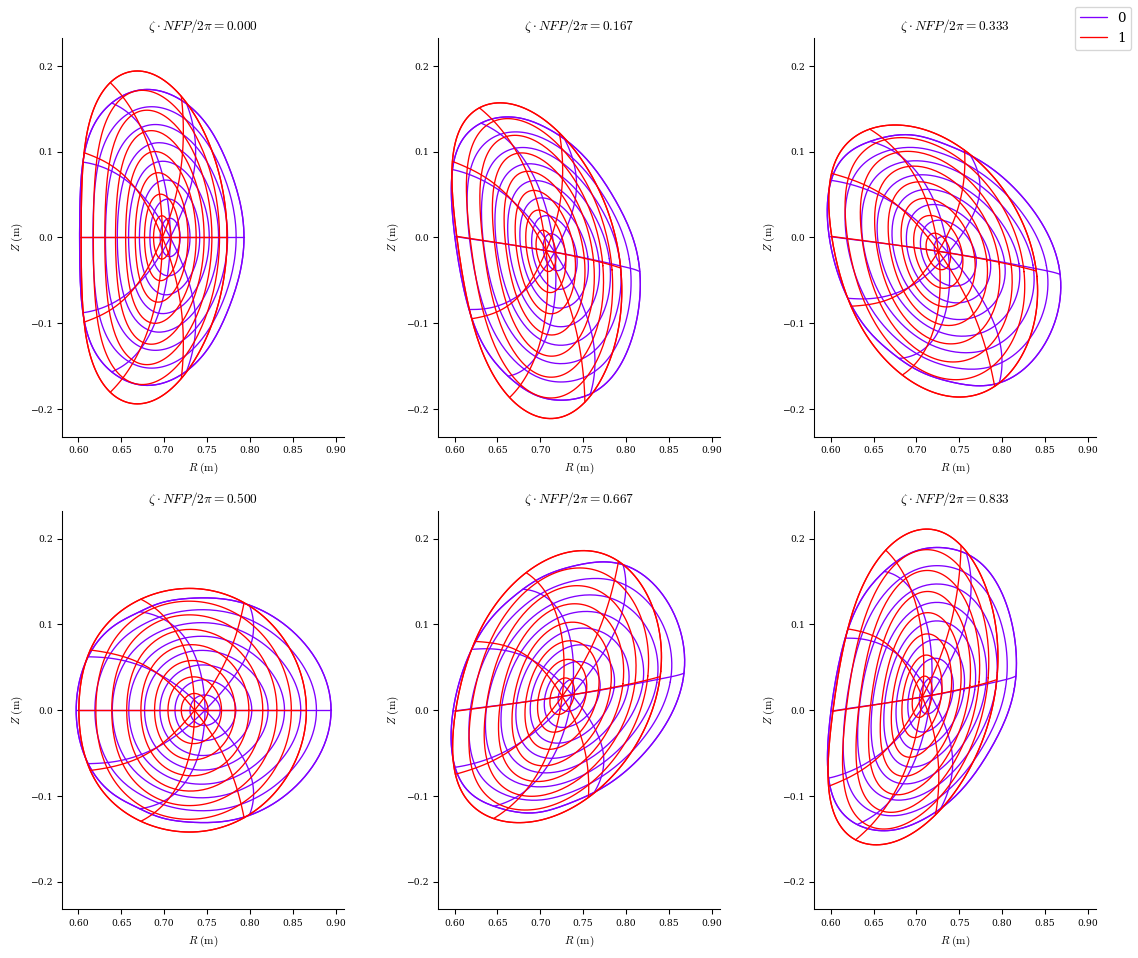

In [36]:
plot_comparison([eqs[-1]] + [veq]);

In [37]:
eq_temp = optimal_perturb(
    eqs[-1],
    bc_objective,
    dRb=True,
    dZb=True,
    dp=False,
    di=False,
    dPsi=False,
    order=2,
    tr_ratio=0.05,
    cutoff=1e-6,
    Jx=None,
    verbose=3,
    copy=True,)
eqs.append(eq_temp)
eqs[-1].solve(maxiter=50);

Perturbing Rb_lmn, Zb_lmn
Computing df
Timer: df/dx computation = 554 ms
Timer: df/dc computation (Rb_lmn, Zb_lmn) = 42.9 sec
Computing dg
Timer: dg/dx computation = 1.05 min
Timer: dg/dc computation (Rb_lmn, Zb_lmn) = 17.2 sec
Computing d^2f
Timer: d^2f computation = 50.1 sec
Computing d^2g
Timer: d^2g computation = 925 ms
Timer: Total perturbation = 2.96 min
||dc||/||c|| = 0.022574723655813162
||dx||/||x|| = 0.06602038717449588
Precomputing transforms
Compiling objective function and derivatives
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 5.829e+03
         Iterations: 27
         Function evaluations: 33
         Jacobian evaluations: 28
Start of solver
Total residual:  8.818e+05  f_rho:  1.189e+03  f_beta:  5.920e+02
End of solver
Total residual:  5.829e+03  f_rho:  6.233e+01  f_beta:  8.816e+01


In [38]:
print_error_summary(eqs)

F^2: 4.8238e-06      B^2: 1.4125e-04
F^2: 8.9097e-01      B^2: 7.4238e-05
F^2: 6.4726e+03      B^2: 4.0593e-05
F^2: 1.0865e+04      B^2: 2.4796e-05
F^2: 2.6143e+03      B^2: 5.2573e-07
F^2: 2.9462e+03      B^2: 3.9991e-07
F^2: 5.8288e+03      B^2: 1.3076e-07


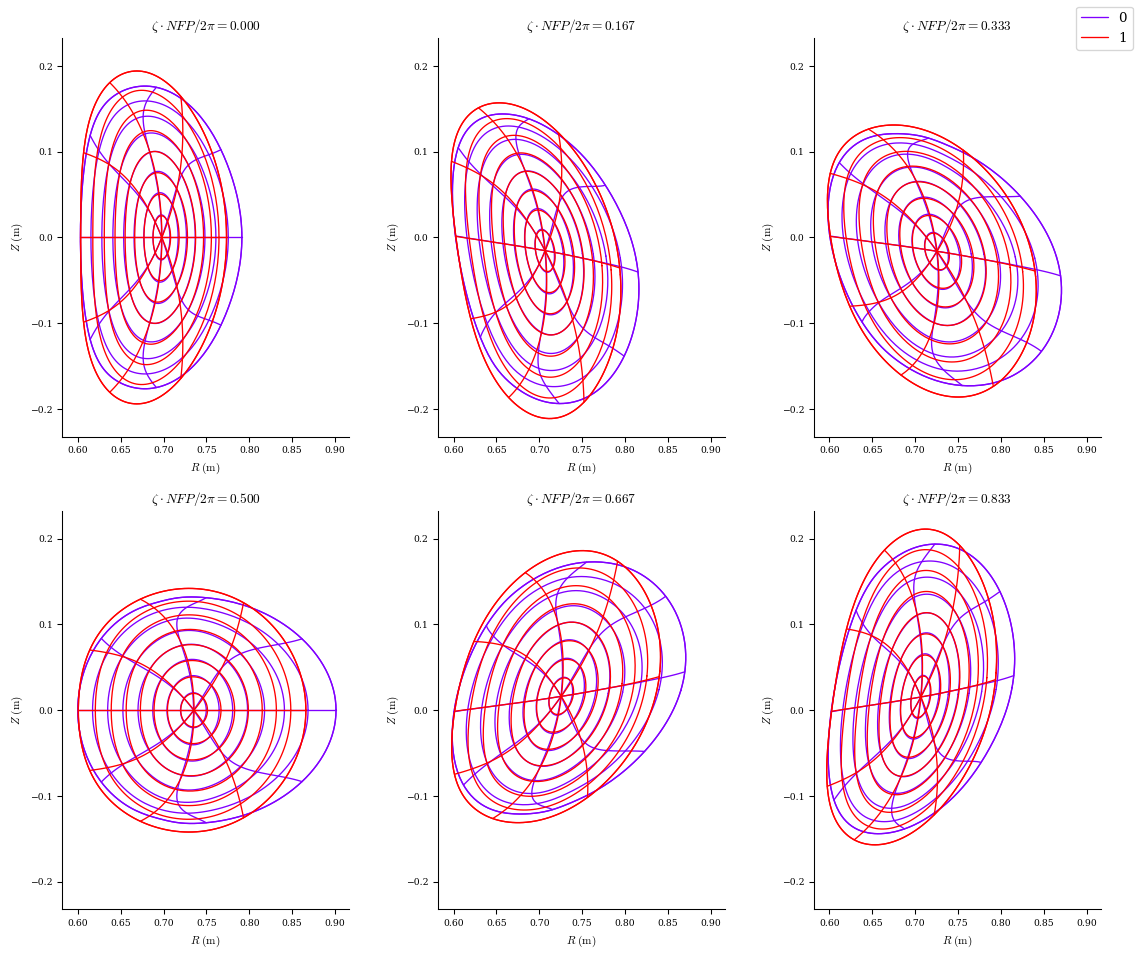

In [39]:
plot_comparison([eqs[-1]] + [veq]);

In [40]:
eqs[-1].Rb_basis = eq.surface.R_basis
eqs[-1].Zb_basis = eq.surface.Z_basis
eq_temp = optimal_perturb(
    eqs[-1],
    bc_objective,
    dRb=True,
    dZb=True,
    dp=False,
    di=False,
    dPsi=False,
    order=2,
    tr_ratio=0.1,
    cutoff=1e-6,
    Jx=None,
    verbose=3,
    copy=True,)
eqs.append(eq_temp)
eqs[-1].objective = eqs[0].objective
eqs[-1].solve(maxiter=50);

Perturbing Rb_lmn, Zb_lmn
Computing df
Timer: df/dx computation = 643 ms
Timer: df/dc computation (Rb_lmn, Zb_lmn) = 42.2 sec
Computing dg
Timer: dg/dx computation = 1.09 min
Timer: dg/dc computation (Rb_lmn, Zb_lmn) = 17.3 sec
Computing d^2f
Timer: d^2f computation = 50.9 sec
Computing d^2g
Timer: d^2g computation = 1.01 sec
Timer: Total perturbation = 3.00 min
||dc||/||c|| = 0.021685280105344516
||dx||/||x|| = 0.13810039628482249
Precomputing transforms
Compiling objective function and derivatives
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 8.658e+02
         Iterations: 12
         Function evaluations: 13
         Jacobian evaluations: 13
Start of solver
Total residual:  6.258e+05  f_rho:  1.027e+03  f_beta:  4.427e+02
End of solver
Total residual:  8.658e+02  f_rho:  2.540e+01  f_beta:  3.296e+01


In [41]:
print_error_summary(eqs)

F^2: 4.8238e-06      B^2: 1.4125e-04
F^2: 8.9097e-01      B^2: 7.4238e-05
F^2: 6.4726e+03      B^2: 4.0593e-05
F^2: 1.0865e+04      B^2: 2.4796e-05
F^2: 2.6143e+03      B^2: 5.2573e-07
F^2: 2.9462e+03      B^2: 3.9991e-07
F^2: 5.8288e+03      B^2: 1.3076e-07
F^2: 8.6582e+02      B^2: 8.8337e-08


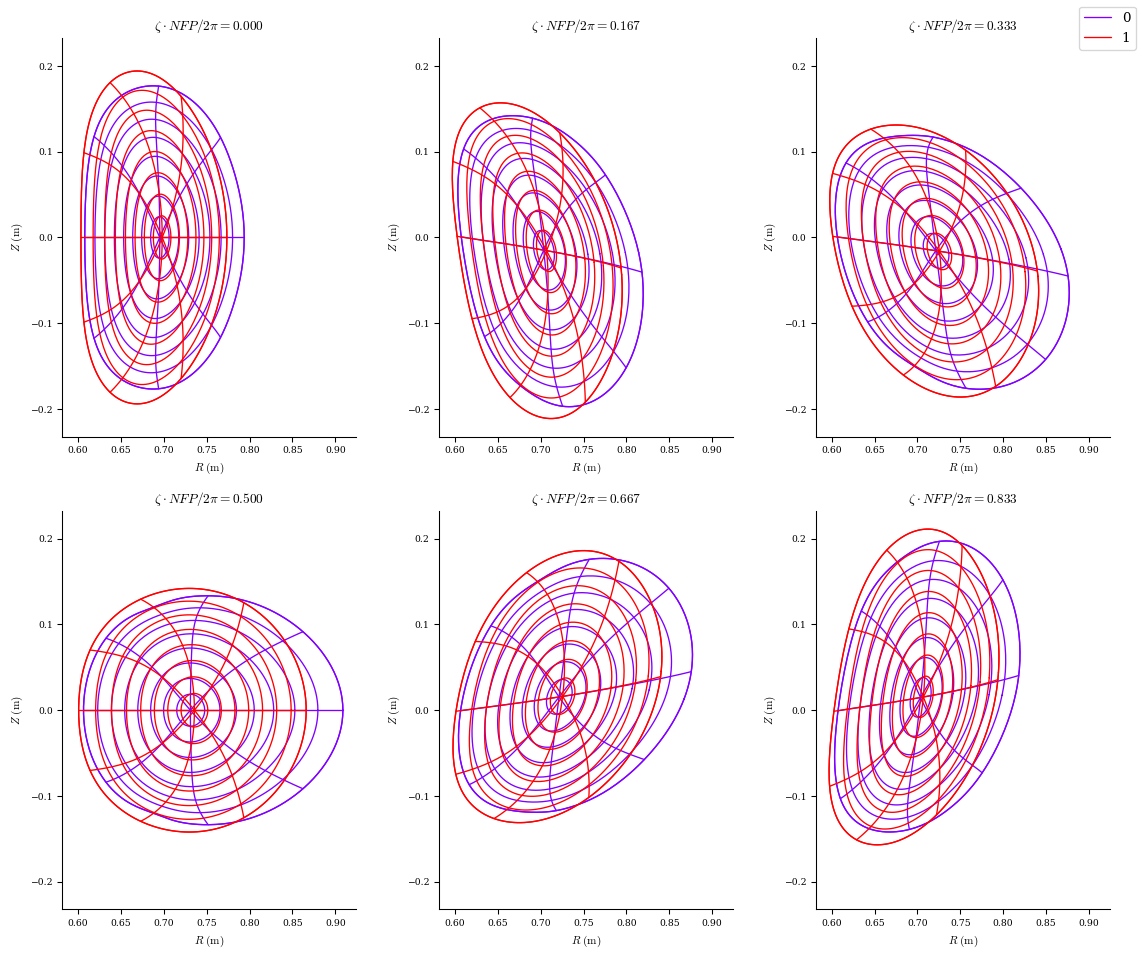

In [42]:
plot_comparison([eqs[-1]] + [veq]);

In [43]:
eqs[-1].Rb_basis = eq.surface.R_basis
eqs[-1].Zb_basis = eq.surface.Z_basis
eq_temp = optimal_perturb(
    eqs[-1],
    bc_objective,
    dRb=True,
    dZb=True,
    dp=False,
    di=False,
    dPsi=False,
    order=2,
    tr_ratio=0.1,
    cutoff=1e-6,
    Jx=None,
    verbose=3,
    copy=True,)
eqs.append(eq_temp)
eqs[-1].objective = eqs[0].objective
eqs[-1].solve(maxiter=50);

Perturbing Rb_lmn, Zb_lmn
Computing df
Timer: df/dx computation = 656 ms
Timer: df/dc computation (Rb_lmn, Zb_lmn) = 42.4 sec
Computing dg
Timer: dg/dx computation = 1.04 min
Timer: dg/dc computation (Rb_lmn, Zb_lmn) = 17.5 sec
Computing d^2f
Timer: d^2f computation = 50.4 sec
Computing d^2g
Timer: d^2g computation = 1.00 sec
Timer: Total perturbation = 2.96 min
||dc||/||c|| = 0.03385759190026441
||dx||/||x|| = 0.1421071673278135
Precomputing transforms
Compiling objective function and derivatives
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 5.962e+03
         Iterations: 18
         Function evaluations: 21
         Jacobian evaluations: 19
Start of solver
Total residual:  1.266e+07  f_rho:  4.796e+03  f_beta:  1.522e+03
End of solver
Total residual:  5.962e+03  f_rho:  6.642e+01  f_beta:  8.667e+01


In [44]:
print_error_summary(eqs)

F^2: 4.8238e-06      B^2: 1.4125e-04
F^2: 8.9097e-01      B^2: 7.4238e-05
F^2: 6.4726e+03      B^2: 4.0593e-05
F^2: 1.0865e+04      B^2: 2.4796e-05
F^2: 2.6143e+03      B^2: 5.2573e-07
F^2: 2.9462e+03      B^2: 3.9991e-07
F^2: 5.8288e+03      B^2: 1.3076e-07
F^2: 8.6582e+02      B^2: 8.8337e-08
F^2: 5.9617e+03      B^2: 2.2539e-07


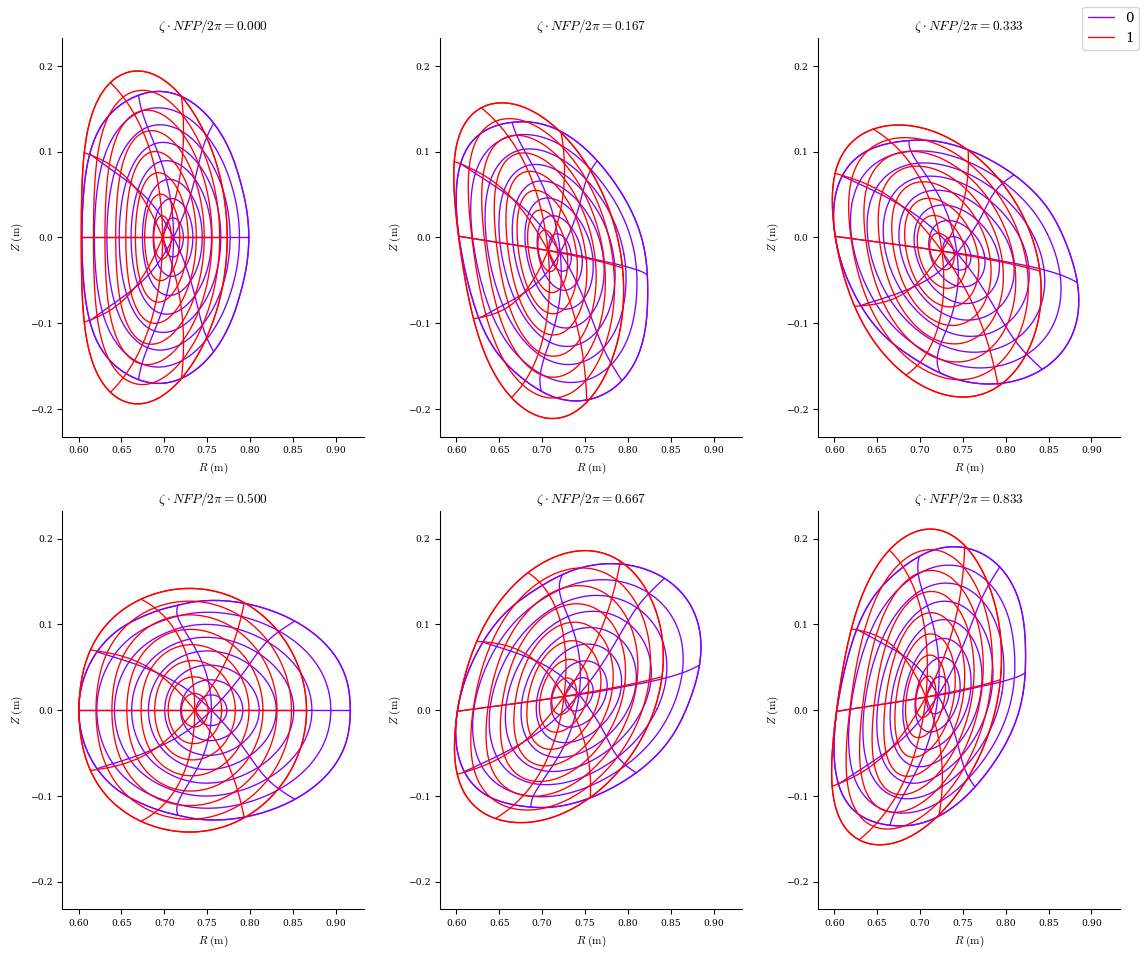

In [45]:
plot_comparison([eqs[-1]] + [veq]);